In [236]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from scipy import stats, optimize
from numpy.polynomial import Polynomial
from astropy.visualization import ZScaleInterval
zscale=ZScaleInterval()

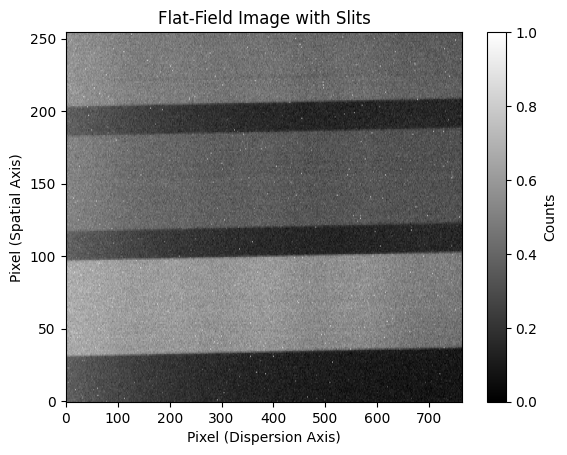

In [237]:
#4.4.1
flat_field = fits.open('../FITS_Files/3.4_Spectropic_Flat_Fields_10_sec.00000003.FLAT.FIT')
flat_data = flat_field[0].data 
# Extracts the 2D data from the first extension of the FITS file 

# Set vmin and vmax for better contrast
vmin = np.percentile(flat_data, 5)   # Lower 5% of the data
vmax = np.percentile(flat_data, 95)  # Upper 95% of the data

# Plot the image to inspect the spectra
plt.imshow(zscale(flat_data), cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Counts')
plt.title('Flat-Field Image with Slits')
plt.xlabel('Pixel (Dispersion Axis)')
plt.ylabel('Pixel (Spatial Axis)')
plt.show()

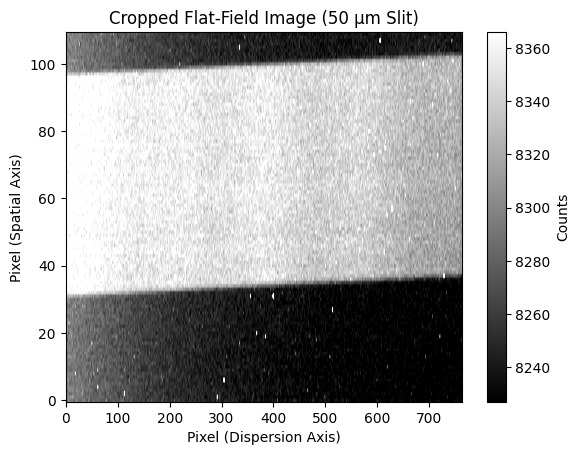

In [238]:

# Open the flat-field file
flat_field = fits.open('../FITS_Files/3.4_Spectropic_Flat_Fields_10_sec.00000000.FLAT.FIT')
flat_data = flat_field[0].data  # Extracts the 2D data from the first extension of the FITS file

# Define the row range for the 50 µm slit (adjust based on actual image)
# From your image, the 50 µm slit is in rows 0 to 110
row_start, row_end = 0, 110  
cropped_flat_field = flat_data[row_start:row_end, :]  # Keep all columns (dispersion axis)

# Set vmin and vmax for better contrast
vmin = np.percentile(flat_data, 5)   # Lower 5% of the data
vmax = np.percentile(flat_data, 95)  # Upper 95% of the data

# Plot the cropped image for the 50 µm slit
plt.imshow(cropped_flat_field, cmap='gray', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(label='Counts')
plt.title('Cropped Flat-Field Image (50 µm Slit)')
plt.xlabel('Pixel (Dispersion Axis)')
plt.ylabel('Pixel (Spatial Axis)')
plt.show()


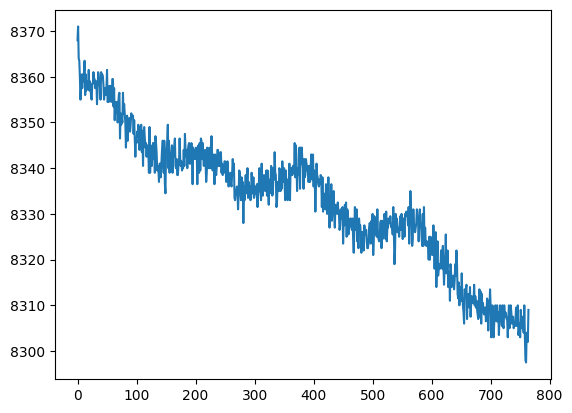

In [239]:
#4.4.2
#Crop data
cropped_flat_field_1D=np.median(cropped_flat_field,axis=0)
plt.plot(cropped_flat_field_1D)
#Cropped 50 micrometer, flattening out 
#For all white part

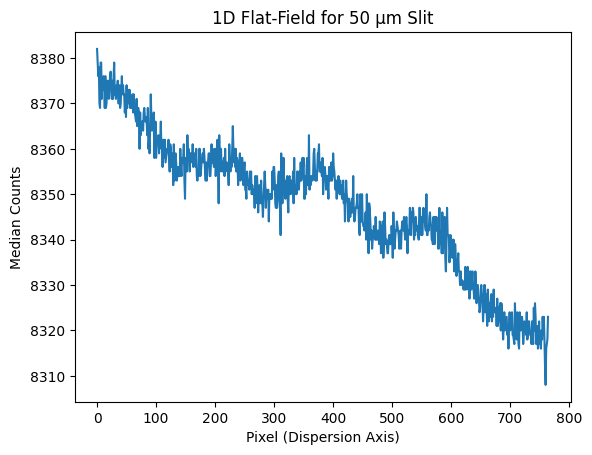

In [240]:
#4.4.2
# Define row range for the 50 µm slit (based on the previous plot)
row_start, row_end = 40,85 
#Specifically take out this range

# Extract the data for the 50 µm slit
slit_flat_data = flat_data[row_start:row_end, :]
# Slices the 2D array flat_data to only include rows between row_start and row_end 
# (corresponding to the 50 µm slit) while keeping all columns (dispersion axis).

# Takes the median of each column (along the spatial axis),
# collapse the 2D image to a 1D array where each element represents the median value of each column.
flat_1d = np.median(slit_flat_data, axis=0)

# Plot the 1D flat-field values against pixel positions
plt.plot(flat_1d)
plt.title('1D Flat-Field for 50 µm Slit')
plt.xlabel('Pixel (Dispersion Axis)')
plt.ylabel('Median Counts')
plt.show()
#This one is for the flat field


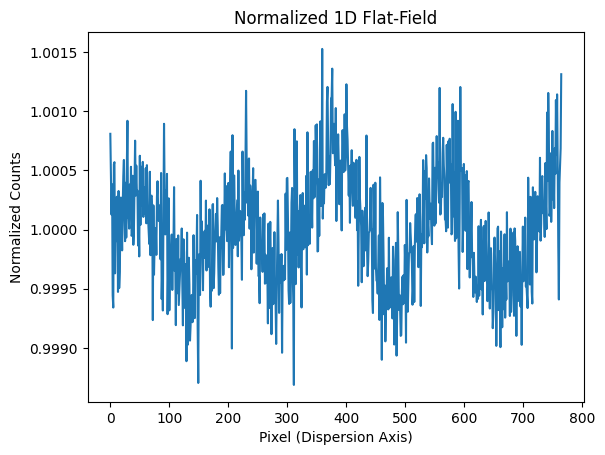

In [241]:
#4.4.3
# Fit a low-order polynomial to the 1D flat-field data
p = Polynomial.fit(np.arange(len(flat_1d)), flat_1d, deg=3)
# np.arange(len(flat_1d)): Generates an array of pixel positions (indices).

# Evaluate the polynomial to get the fit values
fit_values = p(np.arange(len(flat_1d)))

# Normalize the 1D flat-field by dividing by the fit
normalized_flat_1d = flat_1d / fit_values

# Plot the normalized 1D flat-field
plt.plot(normalized_flat_1d)
plt.title('Normalized 1D Flat-Field')
plt.xlabel('Pixel (Dispersion Axis)')
plt.ylabel('Normalized Counts')
plt.show()

# Normalize the 2D flat-field
normalized_flat_2d = slit_flat_data / fit_values[np.newaxis, :]


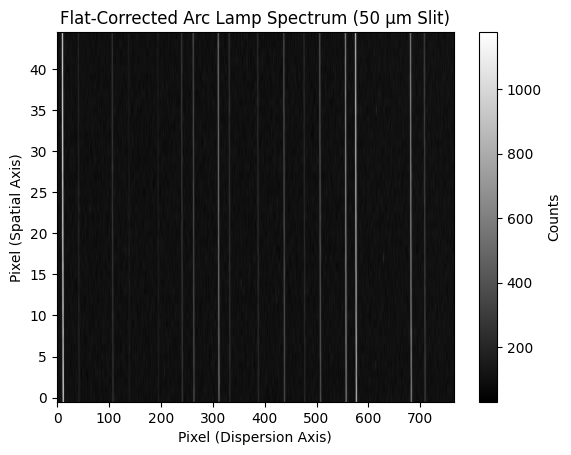

In [242]:
#4.4.4

#divide the arc lamp spectra by the normalized flat field

# Open the arc lamp spectrum
arc_lamp = fits.open('../FITS_Files/3.4_Spectropic_Neon_10_sec.00000000.FIT')
arc_data = arc_lamp[0].data

# Extract the same region for the 50 µm slit
arc_slit_data = arc_data[row_start:row_end, :]

# Apply the normalized flat-field to the arc lamp spectrum
flat_corrected_arc = arc_slit_data / normalized_flat_2d

# Plot the flat-corrected arc spectrum
plt.imshow(flat_corrected_arc, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Counts')
plt.title('Flat-Corrected Arc Lamp Spectrum (50 µm Slit)')
plt.xlabel('Pixel (Dispersion Axis)')
plt.ylabel('Pixel (Spatial Axis)')
plt.show()


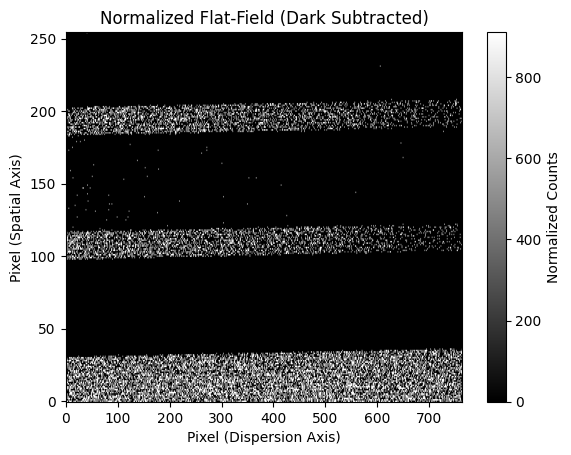

In [243]:
# # Open the flat-field and dark frame files
# flat_field = fits.open('../FITS_Files/3.4_Spectropic_Flat_Fields_10_sec.00000000.FLAT.FIT')
# dark_frame = fits.open('../FITS_Files/3.4_Spectropic_Dark_Frame_10_sec.00000000.DARK.FIT')  

# flat_data = flat_field[0].data  # 2D data from the flat-field
# dark_data = dark_frame[0].data  # 2D data from the dark frame

# # Subtract the dark frame from the flat-field
# flat_dark_subtracted = flat_data - dark_data

# # Proceed with normalization (for example, by dividing by the median or fitting a polynomial)
# # For now, let's normalize by dividing by the median
# flat_normalized = flat_dark_subtracted / np.median(flat_dark_subtracted)

# # Plot the normalized flat-field
# plt.imshow(flat_normalized, cmap='gray', origin='lower', aspect='auto')
# plt.colorbar(label='Normalized Counts')
# plt.title('Normalized Flat-Field (Dark Subtracted)')
# plt.xlabel('Pixel (Dispersion Axis)')
# plt.ylabel('Pixel (Spatial Axis)')
# plt.show()


C:\Users\sunyx\AppData\Local\Temp\ipykernel_22252\2951385378.py:9: RuntimeWarning: divide by zero encountered in divide
  arc_flat_corrected = arc_dark_subtracted / flat_normalized


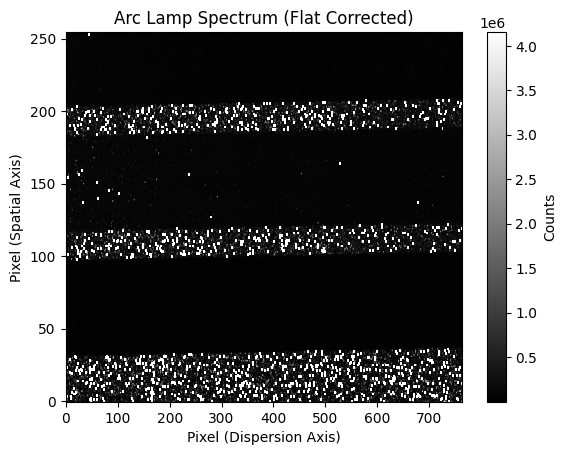

In [244]:
# # Open the arc lamp spectrum
# arc_lamp = fits.open('../FITS_Files/3.4_Spectropic_Neon_10_sec.00000000.FIT')  # Adjust path accordingly
# arc_data = arc_lamp[0].data

# # Subtract dark from the arc lamp spectrum as well
# arc_dark_subtracted = arc_data - dark_data

# # Apply the normalized flat-field to the arc lamp spectrum
# arc_flat_corrected = arc_dark_subtracted / flat_normalized

# # Plot the flat-corrected arc lamp spectrum
# plt.imshow(arc_flat_corrected, cmap='gray', origin='lower', aspect='auto')
# plt.colorbar(label='Counts')
# plt.title('Arc Lamp Spectrum (Flat Corrected)')
# plt.xlabel('Pixel (Dispersion Axis)')
# plt.ylabel('Pixel (Spatial Axis)')
# plt.show()
